In [27]:
from tigramite.pcmci import PCMCI as PCMCI_
from tigramite.independence_tests.parcorr import ParCorr
import tigramite.data_processing as pp

import pandas as pd
import pickle

In [45]:
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
from statsmodels.tools.sm_exceptions import InfeasibleTestError

results = {}

for x1 in range(obs.shape[1]):
    gc2 = {}
    for x2 in range(obs.shape[1]):
        try:
            gc_res = grangercausalitytests(obs[:,[x1,x2]], 3)
            gc_res_lags = {}
            for lag in range(1,3+1):
                gc_res_lags[lag] = gc_res[lag][0]['ssr_ftest'][1]
        except InfeasibleTestError:
            gc_res_lags = {lag:np.nan for lag in range(1,self.maxlags+1)}
        gc2[int(x2)] = gc_res_lags 
    results[int(x1)] = gc2 


In [46]:
gc_res

{1: ({'ssr_ftest': (3.3884921764815416e-14, 0.9999998674716435, 249.0, 1),
   'ssr_chi2test': (3.4157089811119155e-14, 0.9999998525378735, 1),
   'lrtest': (-0.0, 1.0, 1),
   'params_ftest': (49.20154796128821, 2.1709506448984477e-11, 249.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.0, 1.0, 247.0, 2),
   'ssr_chi2test': (0.0, 1.0, 2),
   'lrtest': (-0.0, 1.0, 2),
   'params_ftest': (265.09239048729546, 3.2985586869207675e-62, 247.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.0, 1.0, 245.0, 3),
   'ssr_chi2test': (0.0, 1.0, 3),
   'lrtest': (-0.0, 1.0, 3),
   'params_ftest': (261.0298582133665, 5.474463954651245e-76, 245.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

In [47]:
with open('../../../data/new_data/P1_N5_Nj2_n0.01.pkl', 'rb') as f: 
    observations, dags = pickle.load(f)

In [48]:
obs = observations[1][0]

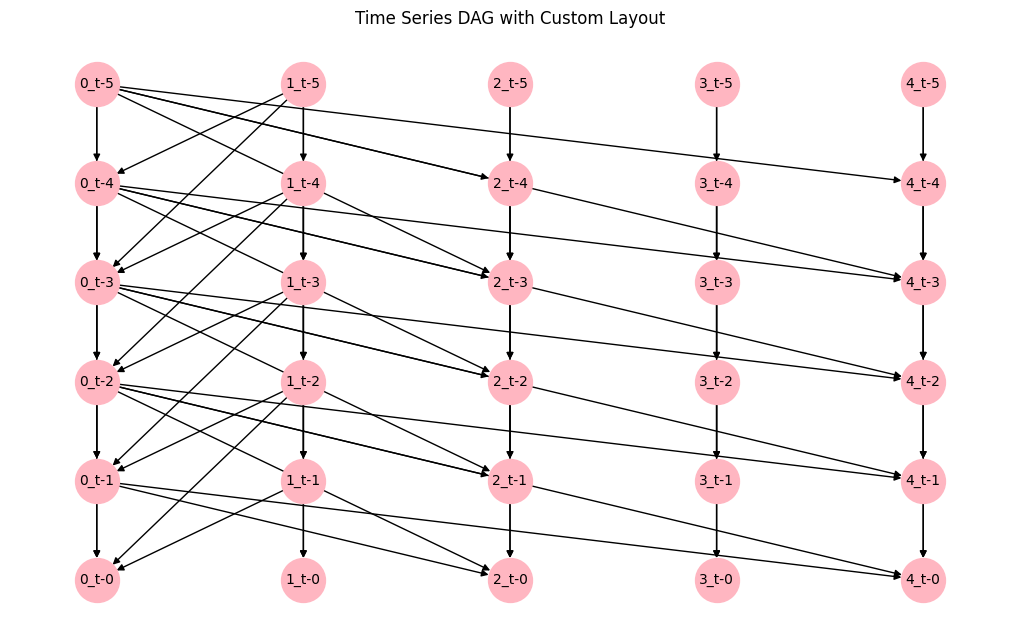

In [51]:
from d2c.data_generation.utils import show_DAG
show_DAG(dags[1][0], obs.shape[1],5)

In [32]:
n_variables = obs.shape[1]
n_variables
maxlags = 2

In [35]:
dataframe = pp.DataFrame(obs)
cond_ind_test = ParCorr()
pcmci = PCMCI_(dataframe=dataframe, cond_ind_test=cond_ind_test, verbosity=1)
results = pcmci.run_pcmci(tau_max=maxlags)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable 0 has 2 link(s):
        (4 -2): max_pval = 0.00000, |min_val| =  0.877
        (1 -2): max_pval = 0.02968, |min_val| =  0.138

    Variable 1 has 2 link(s):
        (3 -2): max_pval = 0.00000, |min_val| =  0.978
        (1 -2): max_pval = 0.00368, |min_val| =  0.184

    Variable 2 has 2 link(s):
        (4 -2): max_pval = 0.00000, |min_val| =  0.878
        (1 -2): max_pval = 0.02440, |min_val| =  0.143

    Variable 3 has 4 link(s):
        (4 -2): max_pval = 0.00042, |min_val| =  0.223
        (3 -2): max_pval = 0.00160, |min_val| =  0.200
        (2 -2): max_pval = 0.00625, |min_val| =  0.174
        (0 -2): max_pval = 0.04841, |min_val| =  0.126

    Variable 4 has 3 link(s):
        (3 -2): max_pval = 0.00000, |min_val| =  0.972
       

In [36]:
pvalues = results['p_matrix']
values = results['val_matrix']

In [39]:


#initialization
pairs = [(source, effect) for source in range(n_variables, n_variables * maxlags + n_variables) for effect in range(n_variables)]
multi_index = pd.MultiIndex.from_tuples(pairs, names=['from', 'to'])
causal_dataframe = pd.DataFrame(index=multi_index, columns=['effect', 'p_value', 'probability', 'is_causal'])

for lag in range(1,maxlags+1):
    for source in range(n_variables):
        for effect in range(n_variables):
            current_pvalue = pvalues[source][effect][lag]
            current_value = values[source][effect][lag]

            is_causal = 0 if current_pvalue > 0.05 else 0 if abs(current_value) < 0.1 else 1
            
            causal_dataframe.loc[(source+lag*n_variables, effect)] = current_value, current_pvalue, None, is_causal

#break the multiindex into columns (from and to)
causal_dataframe.reset_index(inplace=True)

In [40]:
causal_dataframe

,from,to,effect,p_value,probability,is_causal
0,5,0,0.346233,0.0,None,1
1,5,1,0.129992,0.042486,None,1
2,5,2,0.302892,0.000001,None,1
3,5,3,-0.100183,0.120106,None,0
4,5,4,0.071913,0.264135,None,0
5,6,0,0.084733,0.187122,None,0
6,6,1,0.364599,0.0,None,1
7,6,2,0.104191,0.104464,None,0
8,6,3,0.175303,0.006254,None,1
9,6,4,-0.306595,0.000001,None,1


In [18]:
for edge in dag.edges:
    if "t-0" in edge[1]:
        print(edge)

('0_t-2', '0_t-0')
('0_t-2', '2_t-0')
('0_t-2', '4_t-0')
('1_t-2', '0_t-0')
('1_t-2', '1_t-0')
('2_t-2', '2_t-0')
('3_t-2', '3_t-0')
('4_t-2', '4_t-0')
('0_t-1', '0_t-0')
('0_t-1', '2_t-0')
('0_t-1', '4_t-0')
('1_t-1', '0_t-0')
('1_t-1', '1_t-0')
('2_t-1', '2_t-0')
('3_t-1', '3_t-0')
('4_t-1', '4_t-0')


In [15]:
causal_dataframe.loc[causal_dataframe['is_causal'] == 1]   

,from,to,effect,p_value,probability,is_causal
1,5,1,0.216983,0.000732,None,1
2,5,2,0.915234,0.0,None,1
4,5,4,0.224772,0.00045,None,1
5,6,0,0.216983,0.000732,None,1
7,6,2,0.172062,0.007806,None,1
...,...,...,...,...,...,...
117,28,2,0.135575,0.0366,None,1
118,28,3,-0.272986,0.000021,None,1
121,29,1,-0.240664,0.000172,None,1
123,29,3,0.217482,0.000711,None,1


var

In [54]:
import statsmodels.tsa.api as tsa

model = tsa.var.var_model.VAR(obs)
results = model.fit(maxlags=2)

In [63]:
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Apr, 2024
Time:                     14:11:21
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -33.9164
Nobs:                     250.000    HQIC:                  -34.3793
Log likelihood:           2617.71    FPE:                8.58967e-16
AIC:                     -34.6911    Det(Omega_mle):     6.92586e-16
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.375934         0.112821            3.332           0.001
L1.y1        -0.202698         0.086601           -2.341           0.019
L1.y2         0.075041         0.043328            1.732           0.083
L1.y3         0.142364

In [67]:
results.coefs[0][0]

array([-0.20269834,  0.07504075,  0.1423635 , -0.06391496, -0.13464212])

In [59]:
results.coefs[1][2]

array([-0.06081968,  0.03802879, -0.02731581, -0.07646588,  0.87785373])